In [1]:
%matplotlib inline


# Generalized Linear Model


## Gamma Regression
Gamma regression can be used when you have positive continuous response variables such as payments for insurance claims,
or the lifetime of a redundant system.
It is well known that the density of Gamma distribution can be represented as a function of
a mean parameter ($\mu$) and a shape parameter ($\alpha$), respectively,
$$
\begin{align}f(y \mid \mu, \alpha)=\frac{1}{y \Gamma(\alpha)}\left(\frac{\alpha y}{\mu}\right)^{\alpha} e^{-\alpha y / \mu} {I}_{(0, \infty)}(y),\end{align}
$$
where $I(\cdot)$ denotes the indicator function. In the Gamma regression model,
response variables are assumed to follow Gamma distributions. Specifically,

\begin{align}y_i \sim Gamma(\mu_i, \alpha),\end{align}


where $1/\mu_i = x_i^T\beta$.

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n\left\{-\alpha \left( y_i x_i^T \beta - \log \left(x_i^T \beta\right)\right) + \alpha \log \alpha + \left(\alpha - 1\right) \log y - \log \Gamma \left(\alpha\right) \right\}, \text { s.t. }\|\beta\|_0 \leq s .
$$

Here is Python code for solving sparse gamma regression problem:


### Import necessary packages 

In [2]:
import numpy as np
from abess.datasets import make_glm_data
import jax.numpy as jnp
from scope import ScopeSolver, HTPSolver, GraspSolver
from scope.numeric_solver import convex_solver_nlopt

### Set a seed for experimental reproduction

In [3]:
np.random.seed(123)

### Generate the data

In [8]:
n = 500
p = 500
s = 5
data = make_glm_data(n=n, p=p, k=s, family="gamma")
X = np.hstack((np.ones((n, 1)), data.x))
y = data.y
true_params = np.hstack(([0.0], data.coef_))

### Define function to calculate negative log-likelihood of Gamma regression

In [9]:
def gamma_loss(params):
    xbeta = jnp.clip(X @ params, -30, 30)
    return jnp.mean(y * xbeta - jnp.log(xbeta)) 

def convex_solver_gamma(
    loss_fn,
    value_and_grad,
    params,
    optim_variable_set,
    data,
):
    """
    change the initial value of the parameters to let X @ params > 0
    """
    m = np.min(X @ params)
    if m <= 0.0:
        params[0] -= m
    return convex_solver_nlopt(loss_fn, value_and_grad, params, optim_variable_set, data)


### Use scope to solve the sparse gamma regression problem

In [10]:
solver = ScopeSolver(p+1, s+1, always_select=[0], numeric_solver=convex_solver_gamma)
solver.solve(gamma_loss, init_params=np.hstack(([1.0], np.zeros(p))), jit=True)

print("True support set: ", np.nonzero(true_params)[0])
#print("True parameters: ", true_params[1:])
#print("True loss value: ", gamma_loss(true_params))
print("Estimated support set: ", np.sort(solver.support_set)[1:])
#print("Estimated parameters: ", solver.params[1:])
print("Estimated loss value: ", gamma_loss(solver.params))

True support set:  [ 36 242 387 469 479]
Estimated support set:  [ 14  53 242 387 479]
Estimated loss value:  -2.2741227


### More on the results

We can plot the sparse signal recovering from the noisy observations to visualize the results.

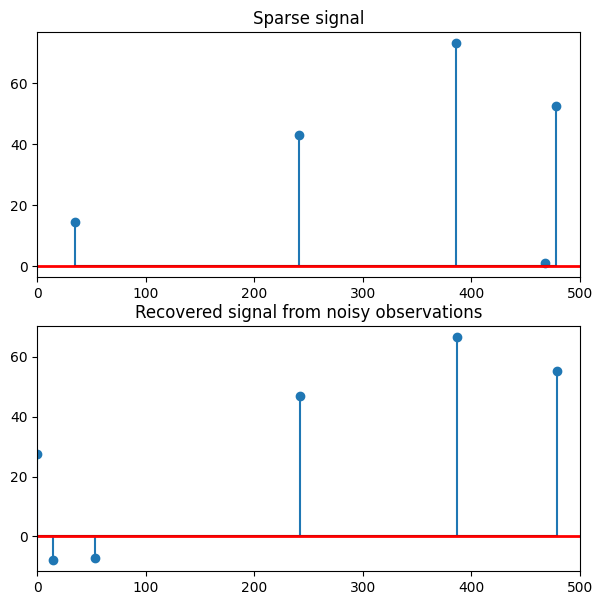

In [11]:
import matplotlib.pyplot as plt
(inx_true,) =  data.coef_.nonzero()
(inx_est,) =  solver.params.nonzero()

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.stem(inx_true, data.coef_[inx_true], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Sparse signal")
#plt.plot(inx_true, true_params[inx_true], drawstyle='steps-post')

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.stem(inx_est, solver.params[inx_est], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")
#plt.plot(inx_est, solver.params[inx_est], drawstyle='steps-post')

plt.show()